# Conv1D - UNet

In [3]:
skip_training = False  # Set this flag to True before validation and submission

In [4]:
# During evaluation, this cell sets skip_training to True

import tools, warnings
warnings.showwarning = tools.customwarn

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

output_dir = tools.select_data_dir('./output/')

The data directory is ../data
The data directory is ./output/


In [256]:
# Select device which you are going to use for training
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [8]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

In [9]:
from data import MotusDataset_best_of, plot_dataset_sample

cutoff = 1 # length of IR
resample_rate = None

trainset = MotusDataset_best_of(root=data_dir, train=True, split=0.05, cutoff=cutoff, resample=resample_rate)
trainloader = torch.utils.data.DataLoader(dataset=trainset)
# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, collate_fn=collate, shuffle=True)

# testset = MotusDataset_best_of(root=data_dir, train=False, cutoff=cutoff, num_tail_samples=num_tail_samples, resample=None)
# testloader = torch.utils.data.DataLoader(dataset=testset)

../data\Motus/best_of/sh_rirs
Dataset with 2 samples. 
Input(channels, time_dim), output(...) shapes: torch.Size([1, 2400]), torch.Size([1, 45600])


Let's visualize the data with some plots, and audio play the head and tail

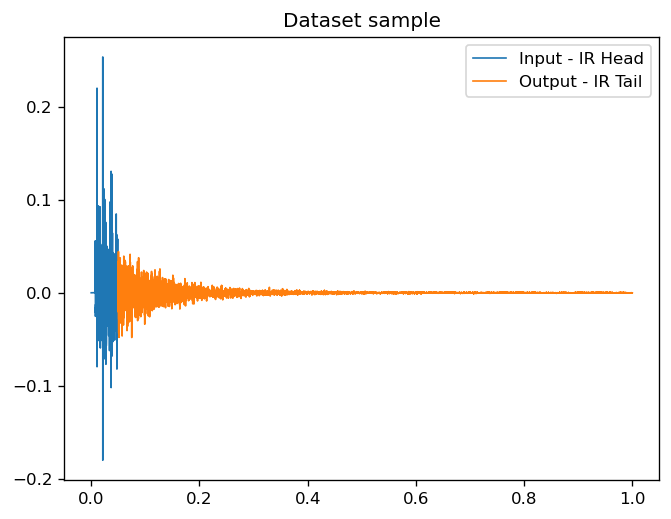

In [10]:
sample_head, sample_tail = plot_dataset_sample(trainset,dpi=120)

In [11]:
from IPython.display import Audio, display

sample_head, sample_tail = trainset[0]
fs = trainset.sample_rate
Audio(torch.cat((sample_head[0], sample_tail[0]), dim=0), rate=fs)

# Architecture

Lightweight model: model ideas from these two papers [Seq-U-Net](https://arxiv.org/pdf/1911.06393.pdf) and [Wave-U-Net](https://arxiv.org/pdf/1806.03185.pdf)

Architecture: 
* Downsampling Block:
    * Conv1D (out_channels=32, kernel_size=16, stride=8) -> skip connection
    * LeakyReLU
    * Dropout (omit?)
    * Conv1D (out_channels=32, kernel_size=3, stride=1)
    * Conv1D (out_channels=32, kernel_size=4, stride=4) + Leaky ReLU
    * Conv1D (out_channels=32, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=out_channels, kernel_size=2, stride=2) + Leaky ReLU 
    - linear layer (hidden size, hidden size) + Leaky ReLU 
    - linear layer (hidden size, 1)


In [272]:
class Downsample_block(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride,
                 dropout=False, 
                 negative_slope=0.01):
        super(Downsample_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size[0], stride=stride[0])
        self.nonlin = nn.LeakyReLU(negative_slope)
        if dropout:
            self.drop = nn.Dropout()
        else:
            self.drop = nn.Identity()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size[1], stride=stride[1])
        
    def forward(self, x):
        skip = self.conv1(x)
        out = self.nonlin(skip)
        out = self.drop(out)
        out = self.conv2(out)
        return out, skip

class Upsample_block(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 convT_stride=2,
                 convT_padding=1,
                 crop_skip=True):
        super(Upsample_block, self).__init__()
        
        self.convT1 = nn.ConvTranspose1d(in_channels, in_channels, kernel_size[0], stride=convT_stride, padding=convT_padding)
        self.conv1 = nn.Conv1d(2*in_channels, out_channels, kernel_size[1])
        self.crop_skip = crop_skip
        
    def forward(self, x, skip):
        out = self.convT1(x)
        print('Upsample block: ', out.shape)
        if self.crop_skip:
            out = torch.concat((out, skip[:,:,-out.shape[-1]:]),dim=1)
        else:
            out = torch.concat((out, skip),dim=1)
        print(out.shape)
        out = self.conv1(out)
        return out

In [273]:
class CNN1D_UNET(nn.Module):
    def __init__(self, in_channels, out_dim, negative_slope=0.01):
        super(CNN1D_UNET,self).__init__()
        self.out_dim=out_dim
        
        self.downsample1 = Downsample_block(in_channels, 
                                            32, 
                                            kernel_size=[16, 3], 
                                            stride=[4, 3], 
                                            negative_slope=negative_slope)
        self.downsample2 = Downsample_block(32, 
                                            128, 
                                            kernel_size=[4, 3], 
                                            stride=[1, 3], 
                                            negative_slope=negative_slope)
        self.downsample3 = Downsample_block(128, 
                                            256, 
                                            kernel_size=[4, 3], 
                                             stride=[1, 3], 
                                            negative_slope=negative_slope)
        self.downsample4 = Downsample_block(256, 
                                            256, 
                                            kernel_size=[4, 3], 
                                            stride=[1, 3], 
                                            negative_slope=negative_slope)
        self.bottleneckConv = nn.Conv1d(256, 256, 3, stride=1)
        self.upsample1 = Upsample_block(256,
                                        256,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=True)
        self.upsample2 = Upsample_block(256,
                                        128,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=True)
        self.upsample3 = Upsample_block(128,
                                        32,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=True)
        self.upsample4 = Upsample_block(32,
                                        32,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=True)
        self.convTs = nn.Sequential(nn.Linear(595, 711, bias=False),
                                    nn.ReLU(),
                                    nn.ConvTranspose1d(32, 32, 16, stride=4, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ReLU(),
                                    nn.ConvTranspose1d(32, 32, 8, stride=4, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ReLU(),
                                    nn.ConvTranspose1d(32, 32, 8, stride=2, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ReLU(),
                                    nn.ConvTranspose1d(32, 32, 4, stride=2, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ReLU(),
                                    nn.ConvTranspose1d(32, 32, 4, stride=1, padding=1),
                                    nn.Conv1d(32, 1, 3)
        )
        
    def forward(self, x, verbose=False):
        """
        Args:
            x of shape (batch_size*IR_len, input_mapped_dim = 4*2*10 = 80): 
            Tensor with transformed input position vectors.
        Returns:
            out of shape (batch_size, 1): value for time step t            
        """
        out, skip1 = self.downsample1(x)
        if verbose: print(out.shape, skip1.shape)
        out, skip2 = self.downsample2(out)
        if verbose: print(out.shape, skip2.shape)
        out, skip3 = self.downsample3(out)
        if verbose: print(out.shape, skip3.shape)
        out, skip4 = self.downsample4(out)
        if verbose: print(out.shape, skip4.shape)
        out = self.bottleneckConv(out)
        if verbose: print('Bottleneck: ', out.shape)
        out = self.upsample1(out, skip4)
        if verbose: print(out.shape)
        out = self.upsample2(out, skip3)
        if verbose: print(out.shape)
        out = self.upsample3(out, skip2)
        if verbose: print(out.shape)
        out = self.upsample4(out, skip1)
        if verbose: print('Last upsample block: ', out.shape)
        out = self.convTs(out)
        if verbose: print(out.shape)
        out = out[:,:,:self.out_dim]
        if verbose: print(out.shape)
        return out

In [274]:
def test_CNN1D_UNET_shapes():
    x = torch.randn(2, 1, 2400)
    channels = x.shape[1]
    out_dim = 45600
    model = CNN1D_UNET(channels, out_dim)
    out = model(x, verbose=True)

test_CNN1D_UNET_shapes()

torch.Size([2, 32, 199]) torch.Size([2, 32, 597])
torch.Size([2, 128, 65]) torch.Size([2, 128, 196])
torch.Size([2, 256, 20]) torch.Size([2, 256, 62])
torch.Size([2, 256, 5]) torch.Size([2, 256, 17])
Bottleneck:  torch.Size([2, 256, 3])
Upsample block:  torch.Size([2, 256, 5])
torch.Size([2, 512, 5])
torch.Size([2, 256, 3])
Upsample block:  torch.Size([2, 256, 5])
torch.Size([2, 512, 5])
torch.Size([2, 128, 3])
Upsample block:  torch.Size([2, 128, 5])
torch.Size([2, 256, 5])
torch.Size([2, 32, 3])
Upsample block:  torch.Size([2, 32, 5])
torch.Size([2, 64, 5])
Last upsample block:  torch.Size([2, 32, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x3 and 595x711)

In [253]:
###### Plotting model output every 500 epochs ######
time1 = np.linspace(0,sample_head.shape[-1]/fs, sample_head.shape[-1])
time2 = np.linspace(time1[-1], sample_tail.shape[-1]/fs+time1[-1], sample_tail.shape[-1])
def plot_model_output(model, dataset, epoch, criterion=None, idx=0, plot=True, xlim=None, ylim=None, save_file=False, filename=None):
    with torch.no_grad():
        model.eval()
        x, y = dataset[idx]
        x = x[None,:,:].to(device).float()
        y = y[None,:,:].to(device).float()
        y_pred = model(x)
        if criterion!= None:
            loss = criterion(y_pred,y)
            print(f"Loss: {loss.item()}")
        
        x_ = torch.flatten(x.cpu())
        y_ = torch.flatten(y.cpu())
        y_pred_ = torch.flatten(y_pred.cpu())
        
        #Plot the data 
        if plot:
            fig, ax = plt.subplots(1)
            ax.plot(time2, y_, linewidth=1)
            ax.plot(time2, y_pred_, ':', linewidth=1)
            ax.set_title(f'Prediction for Epoch {epoch+1}')
            ax.legend(['GT - tail','Predicted - tail'])
            plt.xlabel('Time')
            plt.ylabel('Pressure Amplitude')
        
        if xlim!=None: # xlim in seconds w.r.t entire IR
            plt.xlim(xlim)
        if ylim!=None:
            plt.ylim(ylim)
        if save_file:
            plt.savefig(filename, bbox_inches="tight")

        return x_, y_, y_pred_
    
# x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.995,1], ylim=[-0.0005, 0.0005])

### Training
Initialize the IR-CNN model, then train.

In [254]:
sample_head, sample_tail = trainset[0]
channels = sample_head.shape[0]
out_dim = sample_tail.shape[-1]
cnn_model = CNN1D_UNET(channels, out_dim).to(device)
model_name = "CNN1d_UNET40_L1"

from torchinfo import summary
summary(cnn_model)

Layer (type:depth-idx)                   Param #
CNN1D_UNET                               --
├─Downsample_block: 1-1                  --
│    └─Conv1d: 2-1                       544
│    └─LeakyReLU: 2-2                    --
│    └─Identity: 2-3                     --
│    └─Conv1d: 2-4                       3,104
├─Downsample_block: 1-2                  --
│    └─Conv1d: 2-5                       16,512
│    └─LeakyReLU: 2-6                    --
│    └─Identity: 2-7                     --
│    └─Conv1d: 2-8                       49,280
├─Downsample_block: 1-3                  --
│    └─Conv1d: 2-9                       130,302
│    └─LeakyReLU: 2-10                   --
│    └─Identity: 2-11                    --
│    └─Conv1d: 2-12                      193,802
├─Downsample_block: 1-4                  --
│    └─Conv1d: 2-13                      258,318
│    └─LeakyReLU: 2-14                   --
│    └─Identity: 2-15                    --
│    └─Conv1d: 2-16                      193

Epoch 1. L1 Loss: 0.08253121748566628  L2 Loss: 0.006849124329164624
Epoch 10. L1 Loss: 0.005196635378524661  L2 Loss: 3.753222972591175e-05
Loss: 0.007719576358795166
Epoch 50. L1 Loss: 0.0022356162080541253  L2 Loss: 1.402244697601418e-05
Loss: 0.002587314462289214
Epoch 100. L1 Loss: 0.0021254130406305194  L2 Loss: 1.3547067283070646e-05
Loss: 0.0024343410041183233
Epoch 200. L1 Loss: 0.0020043966942466795  L2 Loss: 1.3158055025996873e-05
Loss: 0.002304637338966131
Epoch 500. L1 Loss: 0.001261292607523501  L2 Loss: 3.4175085374954506e-06
Loss: 0.0013744124444201589


KeyboardInterrupt: 

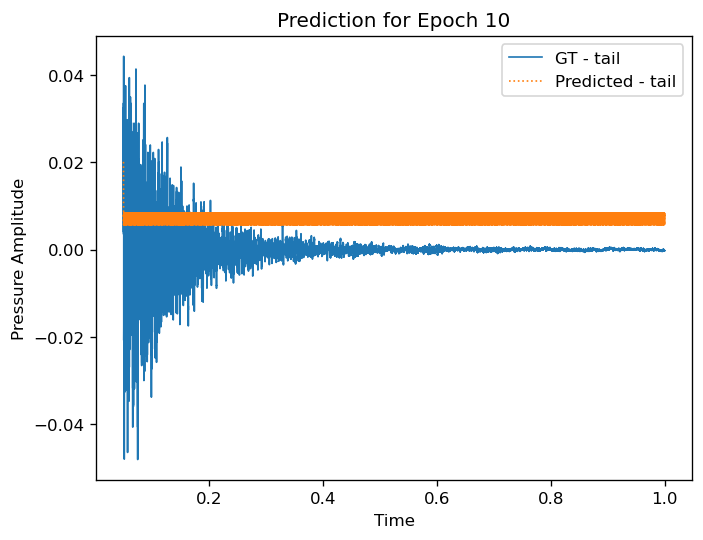

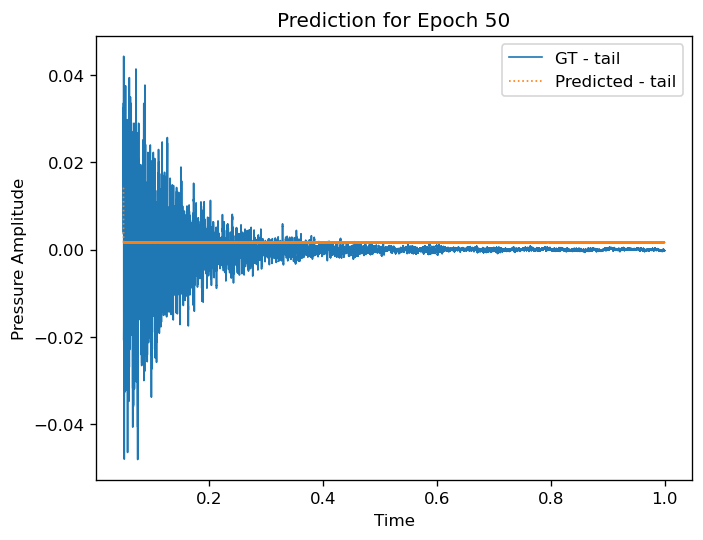

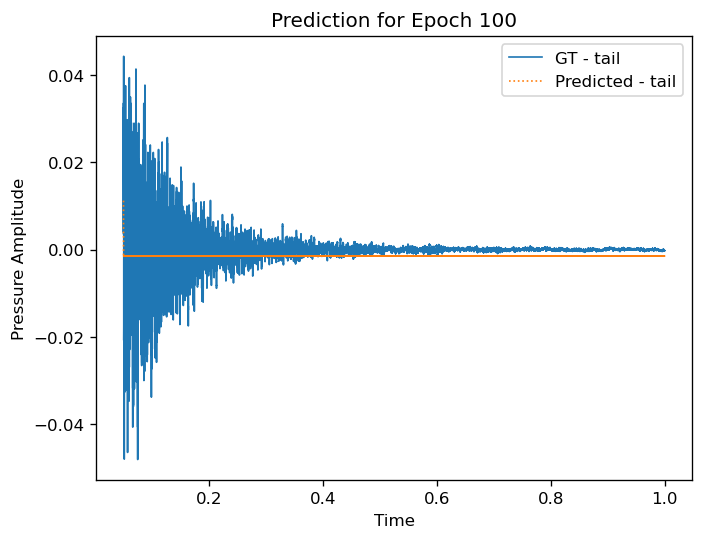

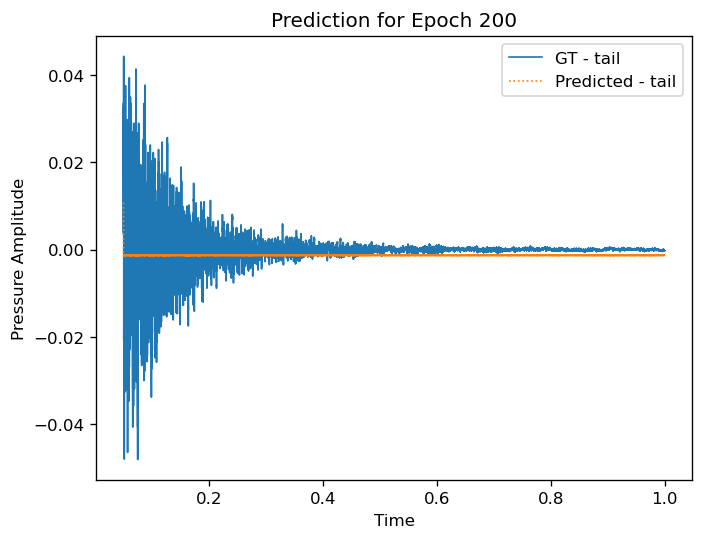

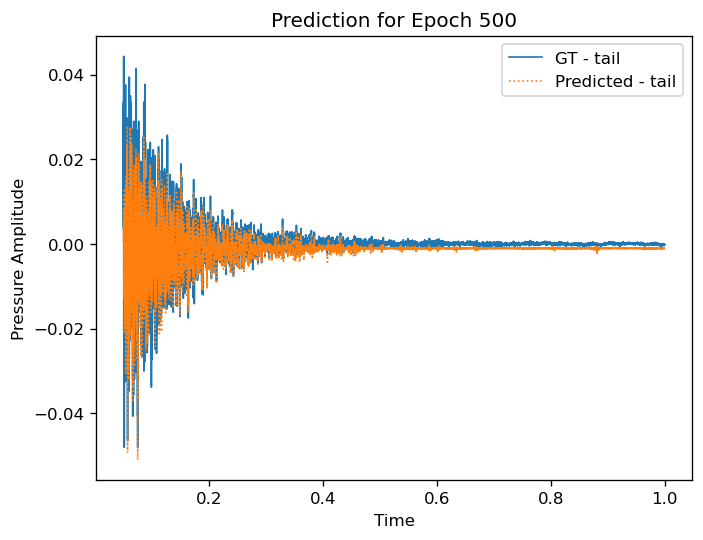

In [255]:
###### Training #######
if not skip_training:
    EPOCHS = 10000
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0005)
    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()
    loss_over_time_l1 = []
    loss_over_time_l2 = []
    epoch_to_plot = [9, 49, 99, 199, 499, 999, 1999, 6999]

    for epoch in range(EPOCHS):
        cnn_model.train()
        total_loss_l1 = 0
        total_loss_l2 = 0
        for x, y in trainloader:
            x = x.to(device).float()
            y = y.to(device).float()
            out = cnn_model(x)
            
            # Zero gradient of optimizer:
            optimizer.zero_grad()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            #total_loss_l1 += F.l1_loss(out,y).item()
            #total_loss_l2 += loss.item()
            total_loss_l1 += loss.item()
            total_loss_l2 += F.mse_loss(out,y).item()
        
        loss_over_time_l1.append(total_loss_l1/len(trainloader))
        loss_over_time_l2.append(total_loss_l2/len(trainloader))
        
        if epoch==0 or epoch==9 or epoch==49 or epoch==99 or epoch==199 or epoch%500==499 or epoch==99998:
            print(f"Epoch {epoch+1}. L1 Loss: {total_loss_l1/len(trainloader)}  L2 Loss: {total_loss_l2/len(trainloader)}")
        if epoch in epoch_to_plot or (epoch%5000==4999 and epoch<50000) or epoch%10000==9999 or epoch==99998:
            x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, 
                              criterion=criterion, 
                              save_file=True, 
                              filename=output_dir+model_name + "_epoch" + str(epoch+1).zfill(5) + "_pred.png")

    # save and plot training loss
    np.save(output_dir+model_name+"_train_loss_L1", loss_over_time_l1)
    
    fig, ax = plt.subplots(1)
    ax.plot(loss_over_time_l1[5:])
    ax.set_yscale('log')
    ax.set_title(f'Training loss L1 over {EPOCHS} Epochs')
    plt.savefig(output_dir+model_name + "_train_loss_L1.png", bbox_inches="tight")
    plt.show()
    
    np.save(output_dir+model_name+"_train_loss_L2", loss_over_time_l2)
    
    fig, ax = plt.subplots(1)
    ax.plot(loss_over_time_l2[5:])
    ax.set_yscale('log')
    ax.set_title(f'Training loss L2 over {EPOCHS} Epochs')
    plt.savefig(output_dir+model_name + "_train_loss_L2.png", bbox_inches="tight")
    plt.show()

In [240]:
if not skip_training:
    tools.save_model(cnn_model, output_dir+model_name+'_e'+str(epoch+1)+'.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to ./output/CNN1d_UNET41_L1_e99999.pth.


In [241]:
model_outputs = np.empty((len(trainset),2,len(sample_tail[0])))

for i in range(len(trainset)):
    _, y, y_pred = plot_model_output(cnn_model, 
                                     trainset, 
                                     epoch, 
                                     plot=False,
                                     idx=i)
    model_outputs[i,0,:] = y
    model_outputs[i,1,:] = y_pred
print(model_outputs)
np.save("./output/"+model_name+"_gt_prediction_e99999", model_outputs)

[[[ 3.24882045e-02  1.36114545e-02  4.18297853e-03 ... -2.37031796e-04
   -2.11183782e-04 -2.35656902e-04]
  [ 3.23620215e-02  1.35263614e-02  3.87081504e-03 ... -3.06241214e-04
   -2.81006098e-04 -1.65909529e-04]]

 [[ 5.66401472e-03  2.51825643e-03 -2.28369958e-03 ...  1.13291295e-04
    1.31989858e-04  1.95784960e-04]
  [ 5.60733303e-03  2.41896510e-03 -2.40760669e-03 ...  9.18097794e-05
    4.34070826e-05  7.43381679e-05]]]


### Evaluation

Plot model prediction, play GT and predicted audio

Loss: 7.524331886088476e-05


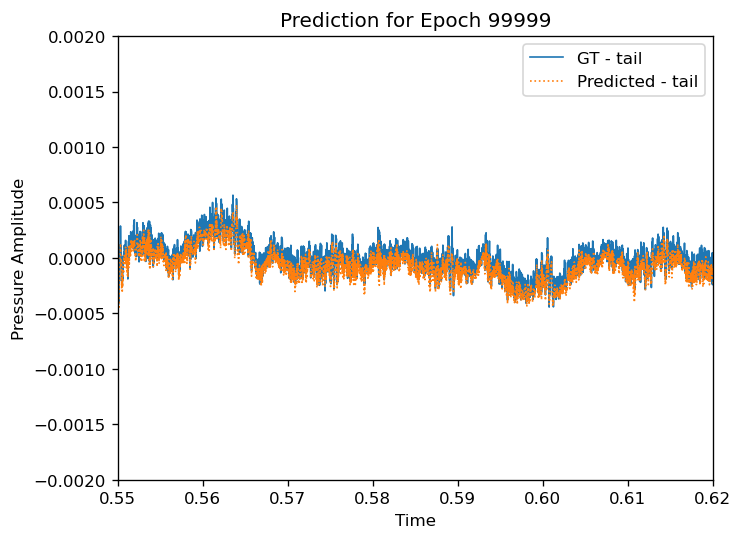

In [242]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, idx=1, criterion=criterion, xlim=[0.55,0.62], ylim=[-0.002,0.002])

Loss: 8.257310400949791e-05


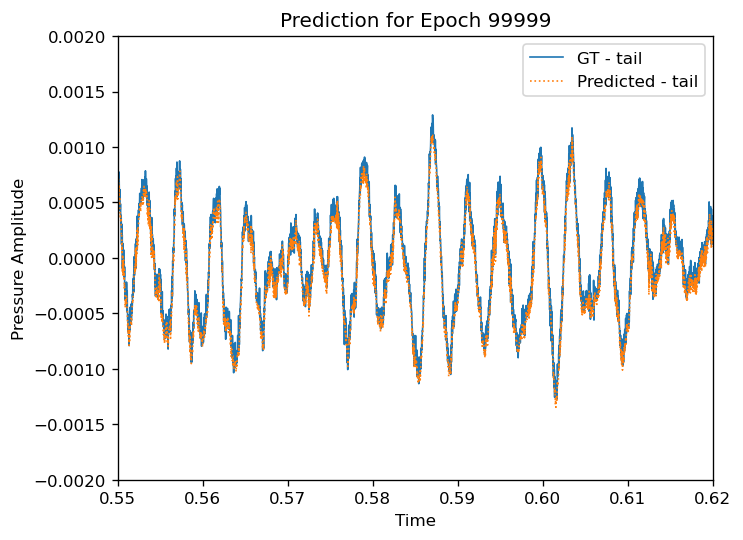

In [243]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, idx=0, criterion=criterion, xlim=[0.55,0.62], ylim=[-0.002,0.002])

Loss: 8.257311128545552e-05


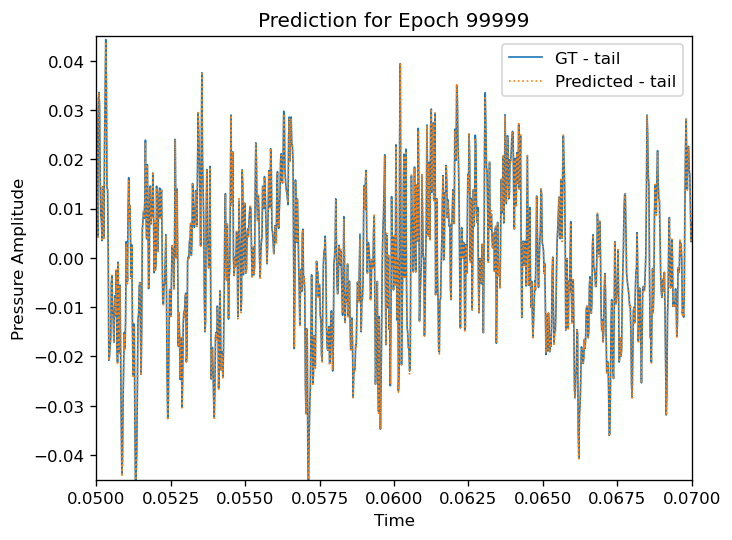

In [244]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.05,0.07], ylim=[-0.045,0.045])

Loss: 8.257310400949791e-05


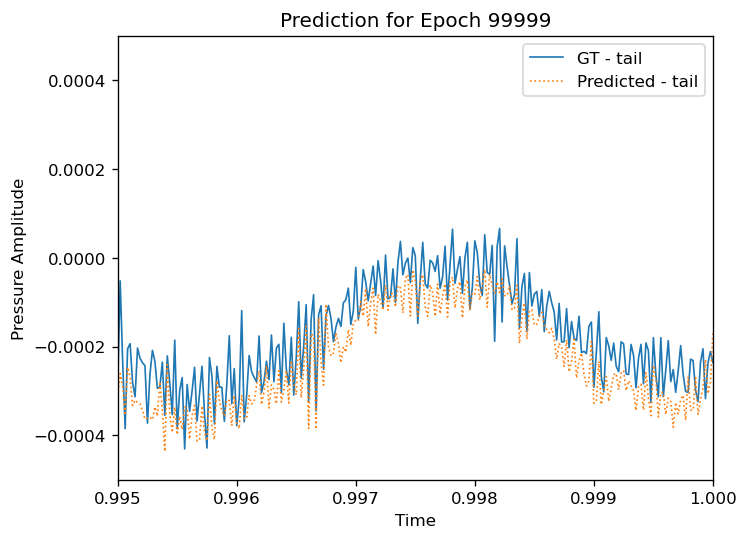

In [245]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, idx=0, criterion=criterion, xlim=[0.995,1], ylim=[-0.0005,0.0005])

In [247]:
# Play GT IR
Audio(torch.cat((x,y)), rate=fs)

In [248]:
# Play predicted IR
Audio(torch.cat((x,y_pred)), rate=fs)

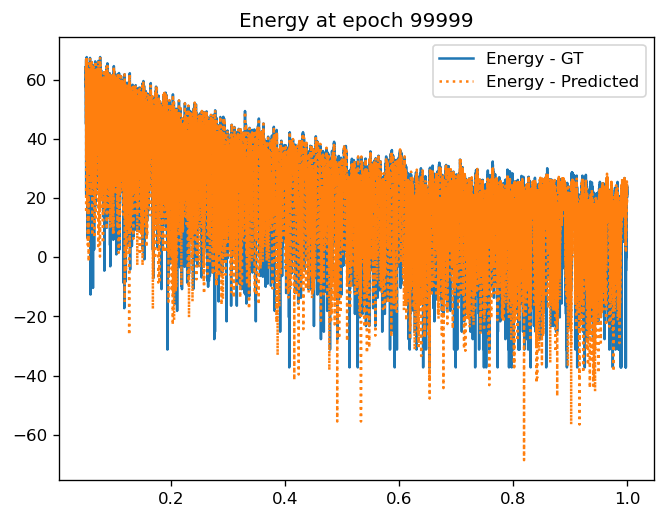

In [249]:
# Energy decay graph
with torch.no_grad():
#     cnn_model.eval()
#     x, y = trainset[0]
#     x = x[None,:,:].to(device).float()
#     y = y[None,:,:].cpu().float()
#     y_pred = cnn_model(x)
    
    pa_ref = 2e-5
    gt_energy = 10*torch.log10((torch.flatten(y)/pa_ref)**2)
    pred_energy = 10*torch.log10((torch.flatten(y_pred.cpu())/pa_ref)**2)
    fig, ax = plt.subplots(1)   
    ax.plot(time2, gt_energy)
    ax.plot(time2, pred_energy, ':')
    ax.legend(['Energy - GT', 'Energy - Predicted'])
    ax.set_title(f'Energy at epoch {epoch+1}')
    plt.savefig(output_dir+model_name + "_energy_e99999.png", bbox_inches="tight")
    plt.show()
    